In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan, load_energy_scans,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)

In [4]:
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)

Number of layers: 59


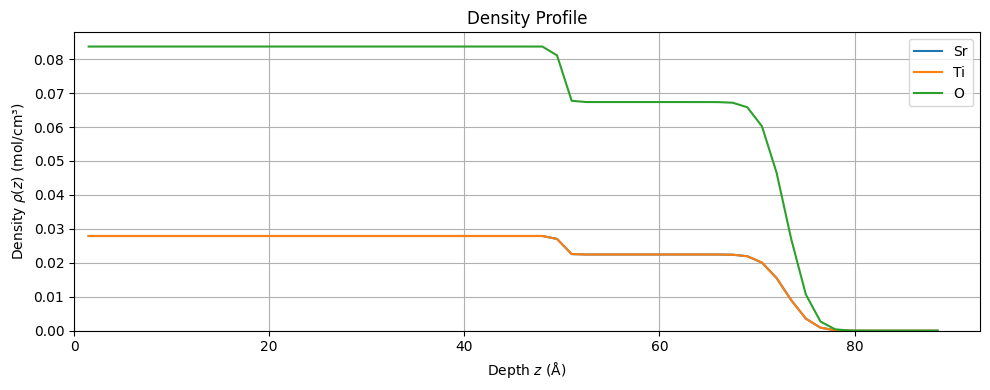

In [6]:
parameters_container = ParametersContainer()
crystal = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=1.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
film = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-film",
    formula="Sr:1,Ti:1,O:3",
    thickness=23.0,
    density=4.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

struc = Structure(name="SrTiO3-struc", n_compounds=2, params_container=parameters_container)
struc.add_compound(0, crystal)
struc.add_compound(1, film)
struc.validate_compounds()
struc.create_layers(step=1.5)

def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")


print(f"Number of layers: {struc.n_layers}")
plot_density_profile_atoms_layers(struc.atoms_layers)

In [7]:
experimental_rscans = load_reflectivity_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_AScans.dat',
    initial_name='B074_AScans',
)
experimental_escans = load_energy_scans(
    path='/Users/niaggar25/Downloads/Experimental RXR data/B074_EScans.dat',
    initial_name='B074_EScans',
)

In [8]:
from rxrmask.optimization import fit_differential_evolution_layers, FitContext, FitTransform, TVRegularizer

Total cost: 1073.506171
Total cost: 19327.776368
Total cost: 16693.032660
Total cost: 22181.608345
Total cost: 20254.101102
Total cost: 18617.798779
Total cost: 23346.406108
Total cost: 21419.006346
Total cost: 21334.914188
Total cost: 21437.562323
Total cost: 26455.831739
Total cost: 20345.494715
Total cost: 24005.059250
Total cost: 26050.184030
Total cost: 22098.046830
Total cost: 21388.724470
Total cost: 19039.148886
Total cost: 19285.379521
Total cost: 21978.948428
Total cost: 24273.924390
Total cost: 18964.364226
Total cost: 23161.060745
Total cost: 17603.384910
Total cost: 21243.272097
Total cost: 18992.180921
Total cost: 16131.626246
Total cost: 18778.198003
Total cost: 18748.272839
Total cost: 20376.335010
Total cost: 19586.158929
Total cost: 21251.318079
Total cost: 21975.088611
Total cost: 22656.140229
Total cost: 19362.055700
Total cost: 17390.054119
Total cost: 20165.508145
Total cost: 22012.024654
Total cost: 20234.549233
Total cost: 22431.276152
Total cost: 24550.900170
T

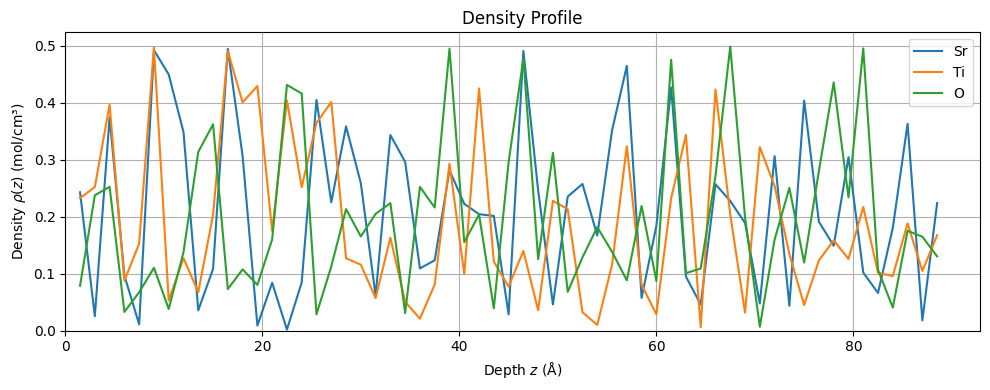

In [9]:
backend = PRReflectivityBackend()
context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln"),
    tv=TVRegularizer(),
    objective="chi2",
)
parameters = [
    param for param in parameters_container.parameters if param.fit
]

res = fit_differential_evolution_layers(
    ctx=context,
    ref_scans=experimental_rscans,
    en_scans=[],
    # en_scans=experimental_escans,
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)